In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

%run functions.ipynb

In [2]:
#import data
train_data = pd.read_csv('../Data/BankChurnersEval.csv')
X_train = train_data.iloc[:,2:-1]
y_train = np.where(train_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)

val_data = pd.read_csv('../Data/BankChurnersVal.csv')
X_val = val_data.iloc[:,2:-1]
y_val = np.where(val_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)

In [3]:
# List all categorical columns
cat_columns = list(X_train.select_dtypes(include=['object']).columns)

In [4]:
# Convert to CatBoost Pool format
train_pool = Pool(X_train, y_train, cat_features=cat_columns)
val_pool = Pool(X_val, y_val, cat_features=cat_columns)

In [5]:
# Define model
cbc = CatBoostClassifier(iterations=1000,
                         learning_rate=0.1,
                         depth=6,
                         loss_function='Logloss',
                         random_seed=0,
                         verbose=200)  # Show progress every 200 iterations

In [6]:
print("Validation results")

Validation results


In [7]:
cbc.fit(train_pool)

0:	learn: 0.5687521	total: 191ms	remaining: 3m 10s
200:	learn: 0.0320151	total: 7.49s	remaining: 29.8s
400:	learn: 0.0145590	total: 15.3s	remaining: 22.9s
600:	learn: 0.0082167	total: 22.9s	remaining: 15.2s
800:	learn: 0.0052389	total: 30.5s	remaining: 7.58s
999:	learn: 0.0039867	total: 37.2s	remaining: 0us


In [8]:
y_pred = cbc.predict(val_pool)
y_pred_prob = cbc.predict_proba(val_pool)[:, 1]  # Get probabilities for the positive class

In [9]:
# Print classification report
print(classification_report(y_val, y_pred, target_names=['Existing Customer', 'Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.98      0.99      0.99      2550
Attrited Customer       0.94      0.91      0.92       488

         accuracy                           0.98      3038
        macro avg       0.96      0.95      0.95      3038
     weighted avg       0.98      0.98      0.98      3038



In [10]:
results = pd.DataFrame(zip(y_val, y_pred_prob), columns=['actual','confidence'])
results_df = pd.DataFrame()

for prob in range(0,125,25):
    col_name = "threshold_" + str(prob)
    results[prob] = results['confidence'] > (prob/100)
    cm = confusion_matrix_class(confusion_matrix(results['actual'], results[prob]),inverse=True)
    #add record to test results df
    new_record = create_results_record(label=col_name,  
                                       cm=cm)
    results_df = pd.concat([results_df, pd.DataFrame([new_record])], ignore_index=True).drop_duplicates()
    
print(results_df.to_string())

           label  accuracy  precision  recall     F1   tp    fp   fn    tn  pred_pos  pred_neg  act_pos  act_neg  total
0    threshold_0     0.161      0.161   1.000  0.277  488  2550    0     0      3038         0      488     2550   3038
1   threshold_25     0.973      0.900   0.939  0.919  458    51   30  2499       509      2529      488     2550   3038
2   threshold_50     0.975      0.938   0.906  0.922  442    29   46  2521       471      2567      488     2550   3038
3   threshold_75     0.969      0.952   0.852  0.899  416    21   72  2529       437      2601      488     2550   3038
4  threshold_100     0.839        NaN   0.000    NaN    0     0  488  2550         0      3038      488     2550   3038


C:\Users\Brendan\AppData\Local\Temp\ipykernel_3244\2792660535.py:23: RuntimeWarning: invalid value encountered in scalar divide
  self.precision = (self.tp/(self.pred_pos))


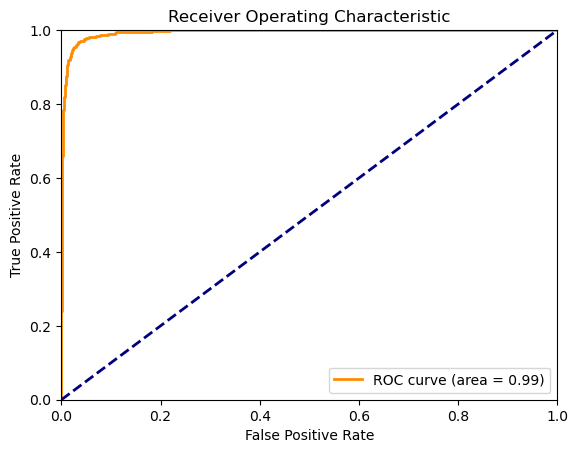

In [11]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

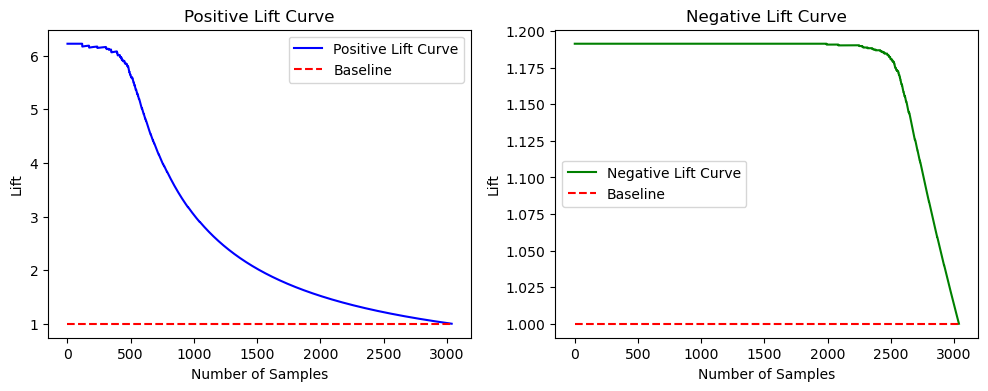

In [12]:
# Plot the lift curves
plot_lift_curves(y_val, y_pred_prob)

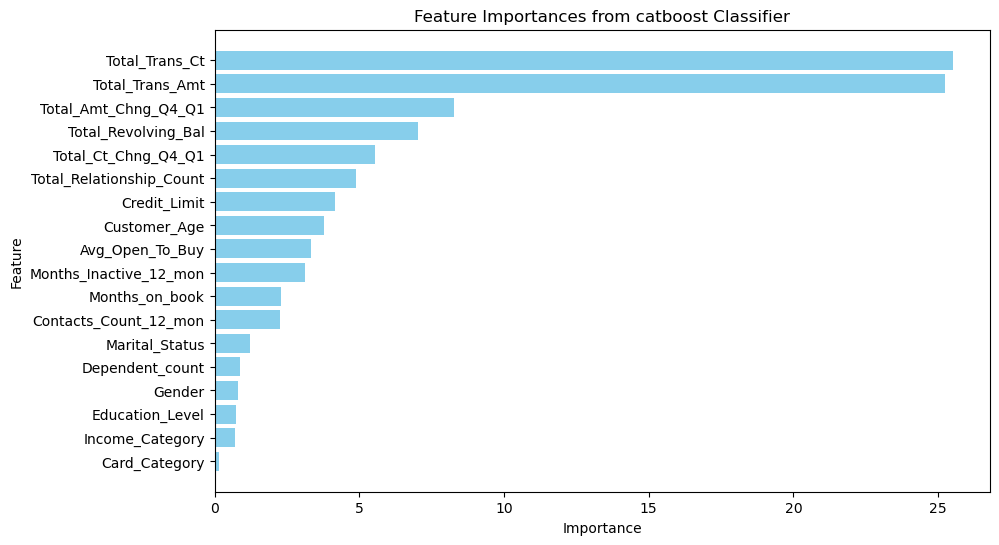

In [13]:
# Get feature importances
#classifier = best_model.named_steps['classifier']
feature_importances = cbc.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from catboost Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()